In [0]:
displayHTML('''<center><br> <img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Amazon_2024.svg" style="width: 200px;"></center><br>''')

In [0]:
displayHTML('''<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #d9345b;">BDA Project |</span> <span style="color: #2a2a83;">Sentiment Analysis on Amazon Reviews of Electronics</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>João Henriques, 20240499</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>
''')

BDA Project | Sentiment Analysis on Amazon Reviews of Electronics 
 
 
 Spring Semester | 2024 - 2025
 
 
 Master in Data Science and Advanced Analytics
 
 
 André Silvestre, 20240502 
 Filipa Pereira, 20240509 
 João Henriques, 20240499 
 Umeima Mahomed, 20240543 
 
 
 Group 37

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 7px; color: white; border-radius: 500px; text-align: center;">
</div>

In [0]:
# EXCLUSIVELY FOR DATABRICKS
#       (Solve the issue of "NameError: name 'torch' is not defined")
#       Source: https://docs.databricks.com/aws/en/machine-learning/train-model/pytorch#install-pytorch
!pip install torch torchvision torchaudio
!pip install transformers
! pip install datasets
#       (Solve the issue "ImportError: cannot import name 'deprecated' from 'typing_extensions' (/databricks/python/lib/python3.9/site-packages/typing_extensions.py")
#       Source: https://github.com/fastapi/fastapi/discussions/9808#discussioncomment-7845188
#               https://github.com/AbdBarho/stable-diffusion-webui-docker/issues/719#issuecomment-2302953924
!pip install typing-extensions==4.11.0

# Restart the Python process to make sure the new libraries are loaded
dbutils.library.restartPython()

     |▏                               | 3.6 MB 5.9 MB

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 116 kB 97.6 MB/s 
     |████████████████████████████████| 64 kB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 103.3 MB/s 
     |████████████████████████████████| 288 kB 101.0 MB/s 
     |████████████████████████████████| 216 kB 71.5 MB/s 
     |████████████████████████████████| 335 kB 65.7 MB/s 
     |████████████████████████████████| 209 kB 91.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-d64fccd7-0823-4e2e-a250-8979be01c97f
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fss

### **PySpark Session**

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics")
         .config("spark.driver.memory", "12g")              # Adjust memory for driver
         .config("spark.executor.memory", "12g")            # Adjust memory per executor
         .getOrCreate())

# Set Spark configurations for convert to Pandas without errors
# Source: https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr
#         https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 📚 **Libraries Import**

In [0]:
# Imports for System Operations
import os
import sys
import time
import datetime
import warnings
from typing import Tuple, List, Optional
from PIL import Image

# Imports for Data Manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Imports for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Imports PySpark
from pyspark.sql import DataFrame
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

# Imports for Machine Learning/Sentiment Analysis
import torch
import transformers
# Source: https://huggingface.co/models
from transformers import pipeline, Pipeline
from datasets import Dataset
from tqdm import tqdm                    # For progress bar

In [0]:
print(transformers.__version__)
print(torch.__version__)

4.52.3
2.7.0+cu126


In [0]:
torch.cuda.empty_cache()  # You may use this command to clear your cache
torch.cuda.is_available() # You may use this command to check if you have gpu or not
# (if False in Google Colab: Make sure your Hardware accelerator is set to GPU. | Runtime > Change runtime type > Hardware Accelerator)

# automatically chose CPU or GPU for inference, depending on your hardware
device = torch.cuda.current_device() if torch.cuda.is_available() else -1
# -1 == CPU ; 0 == GPU
print(device)

-1


---

## 🧮 **Import Databases**

### **🟥 Databricks FileStore**

- If you are using Databricks, you can just use the following code to import the dataset:
    - Otherwise, you replace **`%sh`** with **`!`** and run the command in your terminal. Don't forget to replace the path with your local path.


In [0]:
%sh
# Create the directory for the dataset
mkdir -p /databricks/driver/AfterPreprocessing

# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Reviews)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Reviews)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AfterPreprocessing/df-computers-reviews.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-24 20:29:32--  https://drive.usercontent.google.com/download?id=1gu_63eToPlgGUwp0rm8QvC0P2Ca5ZC5U&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.65, 2607:f8b0:400a:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198851642 (190M) [application/octet-stream]
Saving to: ‘/databricks/driver/AfterPreprocessing/df-computers-reviews.zip’

     0K .......... .......... .......... .......... ..........  0% 3.07M 62s
    50K .......... .......... .......... .......... ..........  0% 6.06M 47s
   100K .......... .......... .......... .......... ..........  0% 5.05M 44s
   150K .......... .......... .......... .......... ..........  0% 7.95M 39s
   200K .......... .......... .......... .......... ..........  0% 7.57M 36s
   250K .......... .......... .......... .......... ..........  0% 21.5M 31s
   300K

In [0]:
%sh
# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Products)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Products)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AfterPreprocessing/df-computers-products.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-24 20:29:43--  https://drive.usercontent.google.com/download?id=1--DOccPoIzK0nUf9J1Ift5ss3xLj3ZNc&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.65, 2607:f8b0:400a:806::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5532593 (5.3M) [application/octet-stream]
Saving to: ‘/databricks/driver/AfterPreprocessing/df-computers-products.zip’

     0K .......... .......... .......... .......... ..........  0% 3.70M 1s
    50K .......... .......... .......... .......... ..........  1% 7.46M 1s
   100K .......... .......... .......... .......... ..........  2% 7.00M 1s
   150K .......... .......... .......... .......... ..........  3% 6.70M 1s
   200K .......... .......... .......... .......... ..........  4% 12.9M 1s
   250K .......... .......... .......... .......... ..........  5% 23.9M 1s
   300K ......

In [0]:
%sh
# Print the contents of the driver directory
ls -lh /databricks/driver/

total 1.3M
drwxr-xr-x 2 root root 4.0K May 24 20:29 AfterPreprocessing
drwxr-xr-x 2 root root 4.0K May 24 18:02 azure
drwxr-xr-x 2 root root 4.0K May 24 18:02 conf
drwxr-xr-x 3 root root 4.0K May 24 20:22 eventlogs
-r-xr-xr-x 1 root root 2.7K May 24 18:02 hadoop_accessed_config.lst
drwxr-xr-x 2 root root 4.0K May 24 20:23 logs
-r-xr-xr-x 1 root root 1.3M May 24 18:02 preload_class.lst


In [0]:
%sh
# Unzip the downloaded files
unzip  /databricks/driver/AfterPreprocessing/df-computers-reviews.zip -d  /databricks/driver/AfterPreprocessing/df-computers-reviews
unzip  /databricks/driver/AfterPreprocessing/df-computers-products.zip -d  /databricks/driver/AfterPreprocessing/df-computers-products

# List the unzipped files
ls -lh  /databricks/driver/AfterPreprocessing/

Archive:  /databricks/driver/AfterPreprocessing/df-computers-reviews.zip
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00000-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/part-00001-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00001-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00004-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet.crc  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/_SUCCESS  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/part-00000-4fd96304-fb62-4356-94dd-38d196ae095f-c000.snappy.parquet  
  inflating: /databricks/driver/AfterPreprocessing/df-computers-reviews/.part-00003-4fd96304-fb62-4356-94dd-38d196ae095

---

### **🧮 PySpark Load Data**

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics_StreamingSimulation")
         .config("spark.driver.memory", "12g")              # Adjust memory for driver
         .config("spark.executor.memory", "12g")            # Adjust memory per executor
         .getOrCreate())

In [0]:
# Import Data (Products and Reviews from Amazon since 2022 - Electronics.Computers | After Preprocessing)

# Read the reviews DataFrame
reviews_df = spark.read.parquet("file:/databricks/driver/AfterPreprocessing/df-computers-reviews")  # Databricks Path

# Read the products/metadata DataFrame
products_df = spark.read.parquet("file:/databricks/driver/AfterPreprocessing/df-computers-products")  # Databricks Path

### **Reviews**

In [0]:
# Verification of the first observation and schema (Reviews)
reviews_df.printSchema()
reviews_df.show(1, vertical=True)

# Number of Observations and Features
print("\nNumber of Observations: ", reviews_df.count())
print("Number of Features: ", len(reviews_df.columns))

root
 |-- review_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)

-RECORD 0----------------------------
 review_id    | 889442               
 rating       | 1                    
 review_text  | Arrived without d... 
 parent_asin  | B07FP8VLXS           
 user_id      | AF4QU6OZEHBMIYPVB... 
 helpful_vote | 0                    
 timestamp    | 1677010612293        
 timestamp_dt | 2023-02-21 20:16:52  
 year         | 2023                 
 month        | 2                    
 day          | 21                   
 day_of_week

### **Products/Metadata**

In [0]:
# Verification of the first observation and schema (Products)
products_df.printSchema()
products_df.show(1, vertical=True)

# Number of Observations and Features
print("\nNumber of Observations: ", products_df.count())
print("Number of Features: ", len(products_df.columns))

root
 |-- meta_title: string (nullable = true)
 |-- meta_average_rating: double (nullable = true)
 |-- meta_rating_number: integer (nullable = true)
 |-- meta_price: double (nullable = true)
 |-- meta_store: string (nullable = true)
 |-- parent_asin: string (nullable = true)

-RECORD 0-----------------------------------
 meta_title          | Barnes & Noble No... 
 meta_average_rating | 4.0                  
 meta_rating_number  | 12                   
 meta_price          | 147.95               
 meta_store          | Barnes & Noble       
 parent_asin         | 0594149290           
only showing top 1 row


Number of Observations:  59418
Number of Features:  6


In [0]:
# Color Palette for Data Visualization
color_palette = [
    "#F79A06",  # Vibrant Orange      0
    "#E46D20",  # Burnt Orange        1
    "#D9345B",  # Reddish Pink        2
    "#C32A68",  # Dark Magenta        3
    "#9F1F74",  # Warm Purple         4
    "#731C7E",  # Deep Purple         5
    "#3D1C87",  # Dark Blue-Purple    6
    "#113D7C",  # Intense Blue        7
    "#0C5A9D",  # Vibrant Blue        8
    "#0987C3"   # Light Blue          9
]

In [0]:
# Sample 1000 reviews to simulate streaming process
streaming_reviews_df = reviews_df.sample(fraction=0.01, seed=2025).limit(1000)
print("\033[1mNumber of Observations in Streaming Reviews DataFrame:\033[0m", streaming_reviews_df.count())
streaming_reviews_df.display()

Number of Observations in Streaming Reviews DataFrame: 1000


review_id,rating,review_text,parent_asin,user_id,helpful_vote,timestamp,timestamp_dt,year,month,day,day_of_week,hour
532508,5,Works great Works great,B09FH5ML5Q,AEKAWB3OV73DPHX5MSQKMYIMUI7A,0,1662852360078,2022-09-10 23:26:00,2022,9,10,7,23
796618,5,"Fantastic iPad cover This is by far the best iPad case I’ve ever had. It is easy to use and it functions exactly as it should, and I love the fact that I can put my pen in the back and have it with it always.",B09YVMS3B1,AE54PYJMBL2P56Z3SZU73PHCO2KQ,0,1673549308788,2023-01-12 18:48:28,2023,1,12,5,18
842043,5,It’s a very good monitor I really like the monitor it comes with the cables a case that helps it stand up. It is very easy to set up. I connect it to my Nintendo switch and the computer. The sound is ok a little low but I guess it’s ok the quality of the screen is very good . We use it to do work and play games.I would recommend it to those looking for something to use as a second screen.The reason I went ahead and got this monitor was because it has good reviews and they where not wrong it works good just what i needed and was looking for.,B0CCP38BHD,AGZVO6UC7XSQTYVNPQVRCYXXO6UQ,0,1675149085258,2023-01-31 07:11:25,2023,1,31,3,7
739311,5,great delivery time and truly an excellent product excellent product in every way,B0BBHDQ699,AGHKNMJW5LALCW72F7XUWQUE4YAA,0,1671553381217,2022-12-20 16:23:01,2022,12,20,3,16
413830,1,"Don’t buy. Stopped working after 35 days Initially the product worked fine. It looks like the original Dell.However, suddenly after 35 days the yellow light on the laptop started blinking and my Dell stopped recognizing the battery: it had died.Returns were accepted only within 30 days.Don’t buy",B0829VZRKN,AF3SAOJQMREIAN3E4JQBCA3JIQOQ,2,1658320940941,2022-07-20 12:42:20,2022,7,20,4,12
337602,5,"Second one, still love it I am amazed how well these work. I have one in my office and I travel with one now. Perfect sound quality.",B08BJ3LK59,AFKBOJR6KOMB32Z5LRIMCM5PWGUQ,0,1654717420935,2022-06-08 19:43:40,2022,6,8,4,19
553877,5,Very durable product Didn’t know it came with a screen protector which is a major plus since it’s for my daughter. Very durable feel and the strap on the back to hold is a plus. Happy about the purchase,B08TR635QP,AHR63JF34AFV4PXSFLZL7LDWEQOQ,0,1663719136120,2022-09-21 00:12:16,2022,9,21,4,0
302353,3,"Love it Perfect size, but in April the snap already broke off 😩",B07W1JV6YM,AEUKBIZNUVL6GUUNUULVED5SPYXQ,0,1653020987410,2022-05-20 04:29:47,2022,5,20,6,4
946083,5,"Excellent product with clear and thorough instructions! We were skeptical about whether this would work, however shortly after completing the very well written instruction, the family was surfing through a HUGE amount of classic games! This has been a blast for everyone in the house!",B09CNRCB7Z,AEURUTD7KTJRB5TRDCHGRIMQG2CQ,0,1678983755082,2023-03-16 16:22:35,2023,3,16,5,16
853466,5,"TEN STARS!!!! This monitor is the best!!! I used to use a USB-A monitor which was OK but this new monitor is far superior. It is much brighter and clear. I highly recommend it. Just remember that it uses a Thunderbolt cable not a USB-C cable. Although it plugs right into my laptop's USB-C port, the cable is different. When I tried using a second USB-C cable it would not work. I contacted customer support and they quickly explained the issue. They then sent me a spare cable for free. This is excellent customer service. I highly recommend this monitor!!!!!",B09M8DYH1B,AGKGVE7JSAYVZIGKXWC42O5ZY25A,2,1675624101837,2023-02-05 19:08:21,2023,2,5,1,19


In [0]:
displayHTML('''
# <span style="color: #ffffff;">Batch Processing (Simulation in Databricks)</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #E46D20;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #E46D20;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Batch Processing (Simulation in Databricks)</b></h2></center>
</div>
''')

# Batch Processing (Simulation in Databricks) 


 
 Batch Processing (Simulation in Databricks)

## **Batch Processing Simulation**

- This section demonstrates the sentiment analysis batch processing on the sampled 1000 reviews.
- It uses the `classify_texts_batch` function to apply the `TXRBSF_sentiment_classifier`.
- The results, including sentiment labels and scores, are shown, and a distribution plot of sentiments is generated.

> This confirms the model and processing pipeline work as expected in the **Databricks Community Edition** *environment on a small scale*.

In [0]:
# Color Palette for Sentiment Analysis
sentiment_colors = {'Positive': '#64C548',
                     'Neutral': '#F47131',
                     'Negative': '#CF213D'}

sentiment_colors_full = {'Positive': '#64C548',
                         'Positive Tendency': '#EBA722',
                         'Neutral': '#F47131',
                         'Negative Tendency': '#F03F42',
                         'Negative': '#CF213D'}

In [0]:
# ============================================
#      Core Classification Functions (Same as previous notebook)
# ============================================

# ------------------------------ [Function to Setup Environment] ------------------------------
def setup_environment(output_path: str) -> str:
    """Set up the environment for saving results (Google Colab, Databricks, or local).

    Args:
        output_path: Path to save classification results.

    Returns:
        str: Adjusted output path for the environment.

    Source:
        - Databricks DBFS: https://docs.databricks.com/en/files/index.html
        - Google Colab Drive: https://colab.research.google.com/notebooks/io.ipynb
    """
    if 'google.colab' in sys.modules:
        from google.colab import drive
        if not os.path.exists('/content/drive/MyDrive'):
            print("Mounting Google Drive")
            drive.mount('/content/drive')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        print("Google Colab environment set up")
        return output_path

    if '/databricks/driver' in os.getcwd():
        adjusted_path = f"dbfs:/FileStore/{output_path.lstrip('/')}"
        dbutils.fs.mkdirs(os.path.dirname(adjusted_path))
        print("Databricks environment set up")
        return adjusted_path

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    print("Local environment set up")
    return output_path

# ------------------------------ [Function to Load Processed IDs] ------------------------------
def load_processed_ids(spark: SparkSession, output_path: str, id_col: str) -> set:
    """Load IDs of already processed rows from an existing results file.

    Args:
        spark: Active Spark session.
        output_path: Path to the existing results file.
        id_col: Name of the ID column.

    Returns:
        set: Set of processed IDs.

    Source:
        - Spark CSV Read: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html
    """
    if not os.path.exists(output_path):
        print("No existing results found")
        return set()

    existing_df = spark.read.csv(output_path, sep='\t', header=True, inferSchema=True)
    processed_ids = set(existing_df.select(id_col).rdd.flatMap(lambda x: x).collect())
    print(f"Loaded {len(processed_ids)} processed IDs")
    return processed_ids

# ------------------------------ [Function to Process Batch] ------------------------------
def process_batch(batch: List[dict], pipeline_instance: Pipeline, id_col: str, text_col: str,
                  output_label_col: str, output_score_col: str, candidate_labels: Optional[List[str]] = None) -> List[dict]:
    """Process a batch of rows using the Hugging Face pipeline with Dataset for GPU efficiency.

    Args:
        batch: List of dictionaries containing row data.
        pipeline_instance: Hugging Face pipeline for classification.
        id_col: Name of the ID column.
        text_col: Name of the text column.
        output_label_col: Name of the output label column.
        output_score_col: Name of the output score column.
        candidate_labels: Optional list of labels for zero-shot classification.

    Returns:
        List[dict]: Processed results with labels and scores.

    Source:
        - Hugging Face Datasets: https://huggingface.co/docs/datasets/v2.21.0/en/index
        - Pipeline Batching: https://huggingface.co/docs/transformers/main_classes/pipelines#pipeline-batching
    """
    texts = [row[text_col] for row in batch]
    ids = [row[id_col] for row in batch]

    # Create a Hugging Face Dataset for batched processing (GPU efficiency)
    dataset = Dataset.from_dict({'text': texts})

    # Process the entire batch at once
    if candidate_labels:
        outputs = pipeline_instance(
            dataset['text'],
            candidate_labels=candidate_labels,
            multi_label=False,
            batch_size=len(texts)  # Process all texts in one batch
        )
    else:
        outputs = pipeline_instance(
            dataset['text'],
            batch_size=len(texts)  # Process all texts in one batch
        )

    results = []
    for i, output in enumerate(outputs):
        label = output['labels'][0] if candidate_labels else output['label']
        score = float(output['scores'][0]) if candidate_labels else float(output['score'])
        results.append({
            id_col: ids[i],
            text_col: texts[i],
            output_label_col: label,
            output_score_col: score
        })

    return results

# ------------------------------ [Function to Save Results] ------------------------------
def save_results(spark: SparkSession, results: List[dict], output_path: str, append: bool = True) -> None:
    """Save classification results to a TSV file, optionally appending to existing results.

    Args:
        spark: Active Spark session.
        results: List of result dictionaries.
        output_path: Path to save the results.
        append: If True, append to existing file; if False, overwrite.

    Source:
        - Spark CSV Write: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameWriter.csv.html
    """
    if not results:
        print("No results to save")
        return

    new_results_df = spark.createDataFrame(results)
    mode = "append" if append and os.path.exists(output_path) else "overwrite"

    new_results_df.write.csv(output_path, sep='\t', header=True, mode=mode)
    # print(f"Results saved to {output_path} in {mode} mode")                   # Debugging

# ------------------------------ [Main Classification Function] ------------------------------
def classify_text_spark_incremental(spark: SparkSession, input_df: DataFrame, pipeline_instance: Pipeline,
                                    id_col: str, text_col: str, output_path: str,
                                    output_label_col: str = "Sentiment", output_score_col: str = "Score",
                                    candidate_labels: Optional[List[str]] = None,
                                    batch_size: int = 32, save_interval: int = 1000) -> Tuple[str, int, float]:
    """Classify text data incrementally using Spark and Hugging Face pipeline, saving results every save_interval rows.

    Args:
        spark: Active Spark session.
        input_df: Input Spark DataFrame with ID and text columns.
        pipeline_instance: Hugging Face pipeline for classification.
        id_col: Name of the ID column.
        text_col: Name of the text column.
        output_path: Path to save results.
        output_label_col: Name of the output label column.
        output_score_col: Name of the output score column.
        candidate_labels: Optional list of labels for zero-shot classification.
        batch_size: Number of rows to process per batch.
        save_interval: Number of rows after which to save results (default: 1000).

    Returns:
        Tuple[str, int, float]: Output path, number of processed rows, execution time.

    Source:
        - Spark toLocalIterator: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.toLocalIterator.html
        - Hugging Face Pipeline: https://huggingface.co/docs/transformers/main_classes/pipelines
    """
    start_time = time.time()
    processed_count = 0       # Track processed texts
    save_counter = 0          # Track save intervals

    # Setup environment and adjust output path
    output_path = setup_environment(output_path)

    # Load processed IDs to avoid reprocessing
    processed_ids = load_processed_ids(spark, output_path, id_col)

    # Filter out already processed rows
    # Note: 'broadcast' to avoid not to send the entire list to each executor
    broadcast_ids = spark.sparkContext.broadcast(processed_ids)
    df_to_process = input_df.select(id_col, text_col) \
        .filter(~F.col(id_col).cast("string").isin(broadcast_ids.value))
    total_rows = df_to_process.count()

    if total_rows == 0:
        print("No new rows to process")
        return output_path, 0, time.time() - start_time

    print(f"Processing {total_rows} new rows")

    # Initialize results buffer and iterator
    results_buffer = []
    data_iterator = df_to_process.toLocalIterator(prefetchPartitions=True)
    batch_data = []
    batch_counter = 0  # Track number of batches processed

    with tqdm(total=total_rows, desc="Classifying Text", unit="row") as pbar:
        for row in data_iterator:
            row_dict = row.asDict()
            if (not row_dict.get(text_col) or
                not isinstance(row_dict[text_col], str) or
                row_dict[text_col].strip() == ''):
                pbar.update(1)
                continue

            batch_data.append(row_dict)

            if len(batch_data) >= batch_size:
                # Process the batch
                batch_results = process_batch(
                    batch_data, pipeline_instance, id_col, text_col,
                    output_label_col, output_score_col, candidate_labels
                )
                results_buffer.extend(batch_results)
                processed_count += len(batch_data)
                pbar.update(len(batch_data))

                # Save results if processed_count reaches the next save interval
                if processed_count >= save_interval * (save_counter + 1):
                    save_results(spark, results_buffer, output_path, append=True)
                    processed_ids.update([result[id_col] for result in results_buffer])
                    save_counter += 1
                    # print(f"Saved {processed_count} rows at interval {save_counter} (batch {batch_counter + 1})") # Debugging

                    # Clear the buffer to manage memory
                    results_buffer = []

                batch_data = []
                batch_counter += 1

        # Process any remaining data
        if batch_data:
            batch_results = process_batch(
                batch_data, pipeline_instance, id_col, text_col,
                output_label_col, output_score_col, candidate_labels
            )
            results_buffer.extend(batch_results)
            processed_count += len(batch_data)
            pbar.update(len(batch_data))

        # Save any remaining results
        if results_buffer:
            save_results(spark, results_buffer, output_path, append=True)
            processed_ids.update([result[id_col] for result in results_buffer])
            print(f"Saved final {len(results_buffer)} rows, total processed: {processed_count}")

    execution_time = time.time() - start_time
    print(f"Processed {processed_count} rows in {execution_time:.2f} seconds")
    return output_path, processed_count, execution_time

#### 🟡 **HuggingFace [twitter-xlm-roberta-base-sentiment-finetunned](https://huggingface.co/citizenlab/twitter-xlm-roberta-base-sentiment-finetunned)**

In [0]:
# Sentiment Analysis | XLM-RoBERTa
# Source: https://huggingface.co/docs/transformers/main_classes/pipelines
#         https://huggingface.co/citizenlab/twitter-xlm-roberta-base-sentiment-finetunned
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
TXRBSF_sentiment_classifier = pipeline("text-classification",                       # Task Name (List Source: https://huggingface.co/tasks)
    model=model_path,                                                               # XLM-RoBERTa
    tokenizer=model_path,                                                           # XLM-RoBERTa
    max_length=512,                                                                 # Maximum Length of the Input Sequence
    truncation=True,                                                                # Truncate the Input Sequence
    device=device                                                                   # Use the automatically detected device
)

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [0]:
# ============================================ APPLY TXRBSF_sentiment_classifier ============================================
# Apply the sentiment classification function to the reviews DataFrame

# 1st Step: Load Hugging Face Pipeline | Sentiment Analysis (Text Classification)
# Already done above

# 2nd Step: Define Output Path on Google Drive
# Since we wanna run in Databricks: Using DBFS (Community Edition)
dbfs_output_dir = "dbfs:/FileStore/AmazonReviews_Results"                                     # Path to save the results
sentiment_output_file_dbfs = os.path.join(dbfs_output_dir, "ReviewsSentiment_TXRBSF_StreamingSimulation.tsv")
sentiment_output_file = sentiment_output_file_dbfs

# 3rd Step: Run the Classification Function | Sentiment Analysis
sentiment_path, sentiment_count, sentiment_time = classify_text_spark_incremental(
    spark=spark,
    input_df=streaming_reviews_df.sample(0.1, seed=2025),   # Using a sample of 100 reviews to show the 
    pipeline_instance=TXRBSF_sentiment_classifier,          # Using the sentiment analysis pipeline
    id_col="review_id",                                     # 'review_id' is a unique ID for reviews
    text_col="review_text",                                 # Column containing the review text
    output_path=sentiment_output_file,                      # Path to save the results
    output_label_col="SentimentLabel",                      # Column for sentiment labels
    output_score_col="SentimentScore",                      # Column for sentiment scores
    batch_size=32,                                          # Batch size for processing
    save_interval=100                                       # Save results every 100 rows
)

# Verify Output
results_sentiment_spark = spark.read.csv(sentiment_path, sep='\t', header=True, inferSchema=True)
print(f"\033[1mSentiment Analysis Results Count: {results_sentiment_spark.count()}")
results_sentiment_spark.limit(5).display()

Databricks environment set up
No existing results found
Processing 103 new rows



Classifying Text: 100%|██████████| 103/103 [01:37<00:00,  1.06row/s]

Saved final 103 rows, total processed: 103
Processed 103 rows in 101.46 seconds


Sentiment Analysis Results Count: 103


SentimentLabel,SentimentScore,review_id,review_text
Positive,0.8777059316635132,862279,Why have I not heard of SK Hynix? I purchased this for a new build because of the reviews so I might as well write one. I also purchased a WD 850X and the SK Hynix is faster. At the end of the day flash memory can only be made so many ways and SK Hynix is the 2nd leading distributor in the world... which I was not aware of (largest is Samsung).I am pleased as punch with this drive. I use it on PC and paired up with a 13900K and 3080 screams in gaming performance. Got over the stated speeds (7100+). I love this drive and will look for SK Hynix products going forward. Highly recommended especially if you can get it on sale ($180).
Neutral,0.9820777773857117,903549,yep it checks out i pushed it to the max and it didnt melt.its loud but wont overheat at all.choo chooo
Neutral,0.9630225300788879,763949,"Looks to be a viable airline Underseat backpack. Normally use larger laptop backpacks as can carry more items, but a larger size means either the overhead bin or checked. This backpack qualifies as an Underseat personal item for most airlines as can pack three days worth of clothes - plus something flat in the rear pocket - and dimensions remain under the 18x14x8 limit. Obviously if ALL pockets were used simultaneously the material would expand beyond 8 inches, but with care it should fit under the average airline seat. Only negative is that the main compartment unzips halfway rather than flipping open completely for potential inspections. Guess the trick would be to pack any Questionable Items - liquids, tweezers, etc - in the TOP half of the bag to make them accessible during security screenings. And can always cover the logo with black electrical or duct tape.Don't have time for detailed measurements, but it slid into my test box so it's less than 18x14x8 and Good Enough. For a bit of a size comparison, was able to place three 11x5 paper towel rolls in the main compartment plus a 12x9x.5 box in the rear compartment. Have seen other products where backpack straps could be completely concealed with a zipper, but straps still count as depth and can live without additional zippers so long as the bag fits. For what it is worth, also found a personal item suitcase that holds FIVE paper towel rolls instead of three since rigid plastic does not stretch the way cloth does, but this backpack can be used once one gets off the plane while luggage is best left at the hotel.FYI: The selling page shows the backpack as smooth an unwrinkled while the product itself is actually a little rumpled, but this is great as it doesn't look like there's a briefcase strapped to my back."
Positive,0.9858313798904419,779550,Affordable case I was skeptical on purchasing an expensive case for my new iPad and so I purchased this one to give it a try and so far I love it! It was super easy to attach. It doesn’t feel expensive but you get what you pay for. So far I’m impressed.
Positive,0.9523775577545166,540086,Work Perfect... Work Perfect...


In [0]:
# Count the number of reviews for each sentiment
TXRBSF_sentiment_pd = results_sentiment_spark.groupBy("SentimentLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Sentiment Counts
TXRBSF_sentiment_pd['%'] = TXRBSF_sentiment_pd['count'] / TXRBSF_sentiment_pd['count'].sum()            # Calculate relative counts
TXRBSF_sentiment_pd['%'] = TXRBSF_sentiment_pd['%'].apply(lambda x: f"{x:.2%}")                         # Format as percentage
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.rename(columns={"SentimentLabel": "Sentiment", "count": "n"}) # Rename columns
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd[["Sentiment", "n", "%"]]                                      # Reorder columns
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.set_index("Sentiment")                                        # Set 'Sentiment' as index
TXRBSF_sentiment_pd

,n,%
Sentiment,,
Positive,57,55.34%
Neutral,28,27.18%
Negative,18,17.48%


---

In [0]:
displayHTML('''
# <span style="color: #ffffff;">Streaming (Simulation)</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #C32A68;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #C32A68;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Streaming (Simulation)</b></h2></center>
</div>
''')

# Streaming (Simulation) 


 
 Streaming (Simulation)

## **Simple Streaming Simulation (Loop-based)**
This section simulates a streaming scenario using a simple loop.
The `streaming_reviews_df_spark` (1000 sampled reviews) is split into smaller chunks.
Each chunk is written to a DBFS directory as a CSV file, simulating data arrival.
A loop then processes these chunks one by one:
1. Reads a chunk.
2. Performs sentiment analysis using the `TXRBSF_sentiment_classifier`.
3. Appends results to a cumulative list/DataFrame.
4. Generates and displays an updated sentiment distribution bar plot for all data processed so far.

Written chunk 0 to dbfs:/mnt/data/streaming_texts/chunk_0.csv
Processing batch 0 with 199 rows

Sentiment Distribution for Batch 0:
  Sentiment    n      %
0  Positive  114  57.3%
1   Neutral   52  26.1%
2  Negative   33  16.6%
Saved plot: dbfs:/mnt/data/plots/plot_batch_0.png


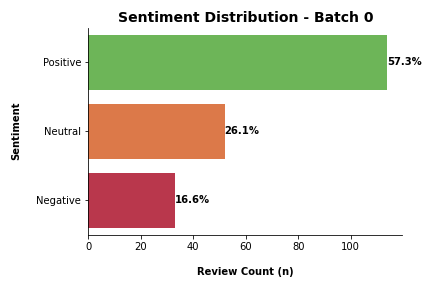

Written chunk 1 to dbfs:/mnt/data/streaming_texts/chunk_1.csv
Processing batch 1 with 199 rows

Sentiment Distribution for Batch 1:
  Sentiment    n      %
0  Positive  100  50.3%
1   Neutral   54  27.1%
2  Negative   45  22.6%
Saved plot: dbfs:/mnt/data/plots/plot_batch_1.png


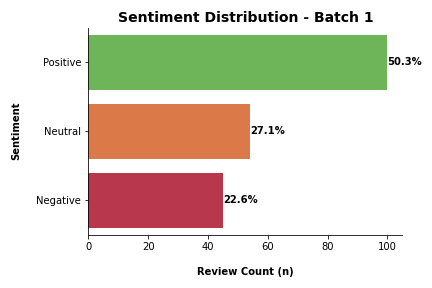

Written chunk 2 to dbfs:/mnt/data/streaming_texts/chunk_2.csv
Processing batch 2 with 199 rows

Sentiment Distribution for Batch 2:
  Sentiment    n      %
0  Positive  115  57.8%
1   Neutral   47  23.6%
2  Negative   37  18.6%
Saved plot: dbfs:/mnt/data/plots/plot_batch_2.png


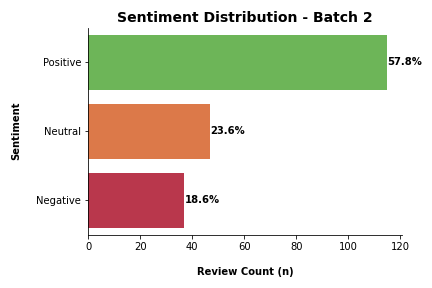

Written chunk 3 to dbfs:/mnt/data/streaming_texts/chunk_3.csv
Processing batch 3 with 199 rows

Sentiment Distribution for Batch 3:
  Sentiment    n      %
0  Positive  107  53.8%
1   Neutral   54  27.1%
2  Negative   38  19.1%
Saved plot: dbfs:/mnt/data/plots/plot_batch_3.png


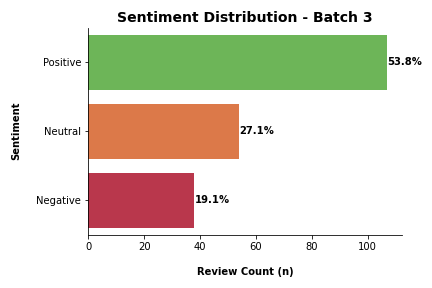

Written chunk 4 to dbfs:/mnt/data/streaming_texts/chunk_4.csv
Processing batch 4 with 200 rows

Sentiment Distribution for Batch 4:
  Sentiment    n      %
0  Positive  103  51.5%
1   Neutral   64  32.0%
2  Negative   33  16.5%
Saved plot: dbfs:/mnt/data/plots/plot_batch_4.png


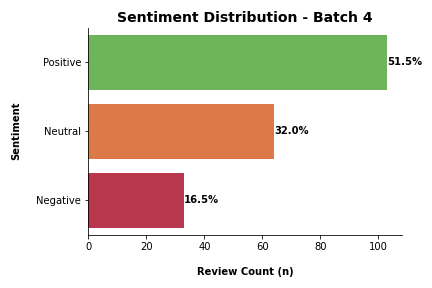

In [0]:
# ============================================
#      Streaming Data Simulation and Processing (As in practical class P5)
# ============================================
# Define schema for reviews data
schema = StructType([
    StructField("review_id", StringType(), True),
    StructField("rating", DoubleType(), True),
    StructField("review_text", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", DoubleType(), True),
    StructField("helpful_vote", DoubleType(), True),
    StructField("timestamp_dt", TimestampType(), True)
])

# Create directories for streaming data and results
dbutils.fs.mkdirs("dbfs:/mnt/data/streaming_texts")
dbutils.fs.mkdirs("dbfs:/mnt/data/sentiment_results")
dbutils.fs.mkdirs("dbfs:/mnt/data/plots")

# Function to classify sentiment for a batch (Adpted for batching simulation/modelling)
def classify_batch(batch_df, batch_id):
    print(f"Processing batch {batch_id} with {batch_df.count()} rows")
    
    # Filter out null or empty text
    batch_df = batch_df.filter(F.col("review_text").isNotNull() & (F.col("review_text") != ""))
    
    # Convert to Pandas for sentiment analysis
    pdf = batch_df.select("review_id", "review_text").toPandas()
    
    # List to store results
    results = []
    
    # Iterate through each row in the Spark DataFrame
    for _, row in pdf.iterrows():
        
        # Extract review text
        text = row["review_text"]
        
        # Classify sentiment using the TXRBSF_sentiment_classifier
        result = TXRBSF_sentiment_classifier(text)[0]
        
        # Store the result
        results.append({
            "review_id": row["review_id"],
            "Sentiment": result["label"],
            "Score": result["score"]
        })
    
    # Convert results to Spark DataFrame
    results_df = spark.createDataFrame(pd.DataFrame(results))
    
    # Save results
    output_path = f"dbfs:/mnt/data/sentiment_results/batch_{batch_id}.tsv"
    results_df.write.mode("overwrite").option("sep", "\t").csv(output_path)
    
    # Analyze sentiment distribution
    sentiment_counts = results_df.groupBy("Sentiment") \
        .count() \
        .orderBy("count", ascending=False) \
        .toPandas()
    
    # Calculate percentages
    sentiment_counts["%"] = (sentiment_counts["count"] / sentiment_counts["count"].sum() * 100).round(1)
    sentiment_counts["%"] = sentiment_counts["%"].apply(lambda x: f"{x:.1f}%")
    sentiment_counts = sentiment_counts.rename(columns={"count": "n"})
    
    # Display table
    print(f"\nSentiment Distribution for Batch {batch_id}:")
    print(sentiment_counts[["Sentiment", "n", "%"]])
    
    # Plot sentiment distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(data=sentiment_counts, x="n", y="Sentiment", palette=sentiment_colors)
    plt.title(f"Sentiment Distribution - Batch {batch_id}", fontsize=14, fontweight='bold')
    plt.xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
    plt.ylabel("Sentiment\n", fontsize=10, fontweight='bold')
    
    # Add percentages on bars
    for i, row in sentiment_counts.iterrows():
        plt.text(row["n"], i, row["%"], va='center', fontsize=10, fontweight='bold')
    
    sns.despine(right=True, top=True)
    plt.tight_layout()
    display()

    # Save plot to DBFS
    plot_path = f"dbfs:/mnt/data/plots/plot_batch_{batch_id}.png"
    plt.savefig(f"/tmp/plot_batch_{batch_id}.png")
    dbutils.fs.cp(f"file:/tmp/plot_batch_{batch_id}.png", plot_path)
    plt.close()

    print(f"Saved plot: {plot_path}")

    # Display the image in Databricks using IPython
    image = Image.open(f"/tmp/plot_batch_{batch_id}.png")
    display(image)

    plt.close()
    
# Simulate streaming by splitting data into chunks
def simulate_streaming(input_df, num_chunks=5):
    total_rows = input_df.count()
    chunk_size = max(1, total_rows // num_chunks)
    
    # Add row numbers for splitting
    from pyspark.sql.window import Window
    import pyspark.sql.functions as F
    window_spec = Window.orderBy(F.lit(1))
    numbered_df = input_df.withColumn("row_num", F.row_number().over(window_spec))
    
    # Process each chunk
    for i in range(num_chunks):
        
        # Calculate start and end row numbers for the chunk
        start = i * chunk_size + 1
        end = (i + 1) * chunk_size if i < num_chunks - 1 else total_rows + 1
        
        # Filter the DataFrame for the current chunk
        chunk_df = numbered_df.filter((F.col("row_num") >= start) & (F.col("row_num") < end)).drop("row_num")

        # Save chunk to simulate streaming
        chunk_path = f"dbfs:/mnt/data/streaming_texts/chunk_{i}.csv"
        chunk_df.write.mode("overwrite").option("header", "true").csv(chunk_path)
        print(f"Written chunk {i} to {chunk_path}")
        
        # Process chunk
        classify_batch(chunk_df, i)
        
        # Wait to simulate streaming
        time.sleep(5)

# Run streaming simulation
simulate_streaming(streaming_reviews_df, num_chunks=5)      # Simulate 5 chunks of data (1000 reviews / 5 = 200 reviews per chunk)

---

In [0]:
displayHTML('''
# <span style="color: #ffffff;">Streaming Advanced (Simulation w/ Databricks Dashboard)</span>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #0C5A9D;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #0C5A9D;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Streaming Advanced (Simulation w/ Databricks Dashboard)</b></h2></center>
</div>
''')

# Streaming Advanced (Simulation w/ Databricks Dashboard) 


 
 Streaming Advanced (Simulation w/ Databricks Dashboard)

## **Advanced Streaming Simulation (Structured Streaming)**
This section demonstrates a more realistic streaming scenario using Spark's Structured Streaming.
1.  **Input Source**: Data is read as a stream from the `streaming_input_path` directory where CSV chunks were previously written. Spark monitors this directory for new files.
2.  **Schema Definition**: A precise schema (`reviews_streaming_schema`) is defined for the incoming streaming data.
3.  **Processing with `foreachBatch`**:
    *   For each micro-batch of data arriving from the stream:
        *   Sentiment analysis is performed using the `TXRBSF_sentiment_classifier` (via the `classify_texts_batch` helper, which internally uses `process_hf_batch`).
        *   The classified results (review_id, SentimentLabel, SentimentScore) are written to an in-memory table named `live_sentiment_results`. This table updates with each micro-batch.
4.  **Output Sink**: The `writeStream` operation uses `format("memory")` and `outputMode("append")` to continuously update the in-memory table. A trigger is set to process data at fixed intervals.
5.  **Live Monitoring**: After starting the stream, you can query the `live_sentiment_results` table using SQL in a separate cell to see the results accumulate and update in near real-time.
6.  **Simulating New Data**: After the initial chunks are processed, a new CSV file with a single review can be manually added to the `streaming_input_path` to observe the system pick it up and update the table.

In [0]:
# ============================================
#      Streaming Data Simulation and Processing (Advanced Simulation)
# ============================================
# Define the full schema for streaming reviews, matching the CSV structure written earlier
# This schema will be used by spark.readStream
reviews_streaming_schema = StructType([
    StructField("review_id", StringType(), True),
    StructField("rating", DoubleType(), True),
    StructField("review_text", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", LongType(), True),
    StructField("helpful_vote", DoubleType(), True),
    StructField("timestamp_dt", TimestampType(), True),
    # Add other columns from streaming_reviews_df_spark if they were written to CSV
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("day_of_week", IntegerType(), True),
    StructField("hour", IntegerType(), True)
])

# Define DBFS paths for this simulation
advanced_streaming_path = "dbfs:/FileStore/BDAProject/AdvancedStreamingSimulation"
advanced_streaming_input_path = os.path.join(advanced_streaming_path, "input_texts")  # Input directory for streaming

# Define paths for checkpointing (required for most streaming queries)
checkpoint_location = os.path.join(advanced_streaming_path, "checkpoint_advanced")
dbutils.fs.rm(checkpoint_location, recurse=True)                                # Clean up checkpoint from previous runs
dbutils.fs.mkdirs(checkpoint_location)

# Read data as a stream from the input directory
# Spark will monitor this directory for new CSV files
streaming_input_df = spark.readStream \
    .schema(reviews_streaming_schema) \
    .option("header", "true") \
    .option("maxFilesPerTrigger", 1).csv(advanced_streaming_input_path)          # Process one new file (chunk) per trigger

# Function to process micro-batch and update dashboard
# This function will be called by foreachBatch
def process_micro_batch_for_dashboard(batch_df: DataFrame, batch_id: int):
    """Process a micro-batch, classify sentiments, and update dashboard table and plot."""
    print(f"\033[1m--- Processing Micro-Batch ID:\033[0m {batch_id} ---")
    
    # Skip empty batches
    if batch_df.count() == 0:
        print(f"Micro-Batch {batch_id} is empty. Skipping.")
        return

    # Show the number of rows in the current micro-batch
    print(f"\033[1mRows in Micro-Batch {batch_id}:\033[0m {batch_df.count()}")
    batch_df.show(5, truncate=False)                                             # Show a sample of the incoming micro-batch

    # Convert batch to list of dictionaries
    batch_dict = [row.asDict() for row in batch_df.select("review_id", "review_text").collect()]

    # Perform sentiment analysis
    classified_results = process_batch(
        batch=batch_dict,
        pipeline_instance=TXRBSF_sentiment_classifier,
        id_col="review_id",
        text_col="review_text",
        output_label_col="SentimentLabel",
        output_score_col="SentimentScore"
    )

    # Convert results to Spark DataFrame
    classified_batch_df = spark.createDataFrame(classified_results)
    
    if classified_batch_df.count() > 0:
        print(f"Micro-Batch {batch_id}: Classified {classified_batch_df.count()} reviews.")
        
        # Select only essential columns for the dashboard table
        output_for_dashboard_df = classified_batch_df.select("review_id", "SentimentLabel", "SentimentScore")
        
        # Write the classified results to a temporary view or an updatable table
        # For Databricks dashboards, creating/replacing a global temp view or writing to a Delta table is common.
        # Here, we'll append to an in-memory table if it exists, or create it.
        # This simulates data being made available for a live dashboard.
        output_for_dashboard_df.write.mode("append").saveAsTable("live_sentiment_results_table")
        print(f"Micro-Batch {batch_id}: Appended results to 'live_sentiment_results_table'.")
    else:
        print(f"Micro-Batch {batch_id}: No results after classification.")

# Start the streaming query using foreachBatch
# This will write to a table that a Databricks SQL query / dashboard can use.
#   Note: For `saveAsTable` to be updatable by appending, the table should ideally be a Delta table.
#         For simplicity in Community Edition, if `live_sentiment_results_table` is a managed Spark table,
#         `mode("append")` works. Let's ensure the table is dropped first for a clean run.
spark.sql("DROP TABLE IF EXISTS live_sentiment_results_table")

print("Starting Advanced Streaming Query to populate 'live_sentiment_results_table'...")
streaming_query_advanced = streaming_input_df.writeStream \
    .foreachBatch(process_micro_batch_for_dashboard) \
    .outputMode("update") \
    .trigger(processingTime="10 seconds") \
    .option("checkpointLocation", checkpoint_location) \
    .start()     
# Note:
# - `outputMode("update")` is used to update the table with new results.
# - `trigger(processingTime="10 seconds")` means the query will process new data every 10 seconds.
# Note: In a real-world scenario, you would use a Delta table for better performance and reliability.


print("Streaming query started. It will process files from:", advanced_streaming_input_path)
print("Query Name:", streaming_query_advanced.name)
print("Query ID:", streaming_query_advanced.id)
print("\n\nResults will be appended to 'live_sentiment_results_table'.")
print("You can query this table in a new cell: SELECT * FROM live_sentiment_results_table")
print("Or for aggregated view: SELECT SentimentLabel, COUNT(*) as Count FROM live_sentiment_results_table GROUP BY SentimentLabel ORDER BY Count DESC")

Starting Advanced Streaming Query to populate 'live_sentiment_results_table'...
Streaming query started. It will process files from: dbfs:/FileStore/BDAProject/AdvancedStreamingSimulation/input_texts
Query Name: None
Query ID: 6b39ad4d-78de-4ce6-b3c3-f8ba8c896c72


Results will be appended to 'live_sentiment_results_table'.
You can query this table in a new cell: SELECT * FROM live_sentiment_results_table
Or for aggregated view: SELECT SentimentLabel, COUNT(*) as Count FROM live_sentiment_results_table GROUP BY SentimentLabel ORDER BY Count DESC


The streaming query above has been started. It will monitor the `dbfs:/FileStore/BDAProject/StreamingSimulation/input_texts` directory.

---

## Instructions
**To observe the streaming process:**
1. **Ensure the streaming query is running**: The query should be active in the original notebook, processing the `reviews_chunk_*.csv` files from the input directory.
2. **Run one chunk at a time**: Each cell below writes a new CSV file with two reviews to the input directory. Wait 10–15 seconds between running each cell to allow the streaming query to process the file.
3. **Monitor results**: Check the original notebook for processing logs, including sentiment distribution tables and plot paths. You can also query the results in a new tab with:
   ```sql
   SELECT * FROM live_sentiment_results_table;
   ```
   <br>

   ```sql
   SELECT SentimentLabel, COUNT(*) as Review_Count
   FROM live_sentiment_results_table
   GROUP BY SentimentLabel
   ORDER BY Review_Count DESC;
   ```

#### Notes
- Each chunk contains two reviews with different ratings and sentiments to demonstrate varied results.
- The files are named `new_single_review_batch_1.csv`, `new_single_review_batch_2.csv`, etc., to avoid overwriting.
- If you run multiple chunks quickly, the streaming query will process them in order, thanks to the `maxFilesPerTrigger=1` setting.

---

## **To simulate a new review arriving:**
After the initial files are processed (wait for about a minute or check the logs), you can manually add a new CSV file to the `dbfs:/FileStore/BDAProject/StreamingSimulation/input_texts` directory. The stream will pick it up in the next trigger interval.

For example, create a file `new_single_review.csv` with the following content (ensure it matches the `reviews_streaming_schema` structure, including a header):
```csv
review_id,rating,review_text,parent_asin,user_id,timestamp,helpful_vote,timestamp_dt,year,month,day,day_of_week,hour
new_review_001,5.0,"This is an amazing new product I just received and it works perfectly!",new_asin_001,new_user_001,1672531200,2,"2023-01-01T00:00:00.000+0000",2023,1,1,1,0
```
You can use `dbutils.fs.put()` to create this file in DBFS:

In [0]:
# # Run this in a new Python cell AFTER the initial chunks are processed by the stream
# import os

# advanced_streaming_path = "dbfs:/FileStore/BDAProject/AdvancedStreamingSimulation"
# advanced_streaming_input_path = os.path.join(advanced_streaming_path, "input_texts")  # Input directory for streaming

# new_review_data = """review_id,rating,review_text,parent_asin,user_id,timestamp,helpful_vote,timestamp_dt,year,month,day,day_of_week,hour
# new_review_001,5.0,"This is an amazing new product I just received and it works perfectly!",new_asin_001,new_user_001,1672531200,2,"2023-01-01T00:00:00.000+0000",2023,1,1,1,0
# new_review_002,1.0,"Unfortunately this item broke after one day very disappointing.",new_asin_002,new_user_002,1672531201,0,"2023-01-01T00:00:01.000+0000",2023,1,1,1,0
# """
# dbutils.fs.put(os.path.join(advanced_streaming_input_path, "new_single_review_batch.csv"), new_review_data, overwrite=True)
# print(f"Simulated new review file written to {os.path.join(advanced_streaming_input_path, 'new_single_review_batch.csv')}")

Then, re-run the SQL queries to see the new review(s) processed and added to the table.

**Stopping the Stream**

Once you are done observing, you can stop the streaming query to free up resources.

In [0]:
streaming_query_advanced.stop()
print("Advanced streaming query stopped.")

Advanced streaming query stopped.
